In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# 21. Séries temporais por hora

/tmp/ipython-input-1187652280.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean()


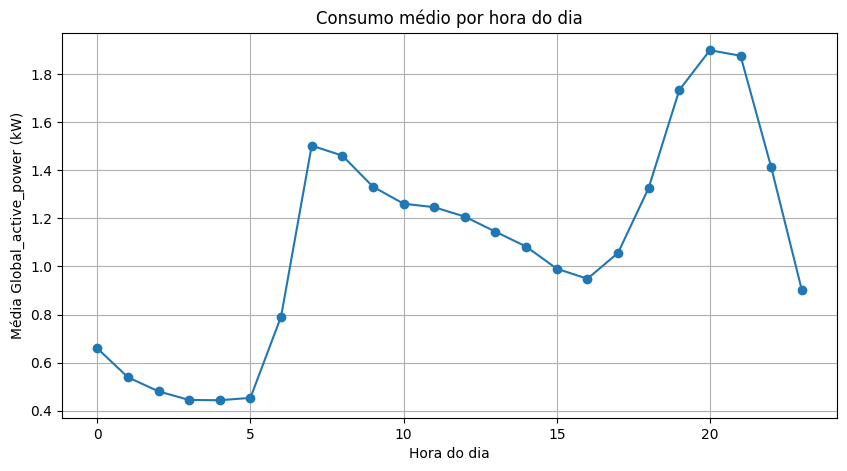

Horários de maior consumo médio:
Hour
20    1.899073
21    1.876063
19    1.733428
7     1.502373
8     1.460940
Name: Global_active_power, dtype: float64


In [9]:
# Carregar dados
cols = ['Date','Time','Global_active_power','Global_reactive_power','Voltage','Global_intensity',
'Sub_metering_1','Sub_metering_2','Sub_metering_3']


df = pd.read_csv("household_power_consumption.txt", sep=';', names=cols, header=0,
na_values='?', low_memory=False)


# Criar índice datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)


# Converter para numérico
df = df.apply(pd.to_numeric, errors='coerce')


# Reamostrar para 1 hora
df_hourly = df.resample('1H').mean()


# Horários de maior consumo médio
df_hourly['Hour'] = df_hourly.index.hour
hourly_mean = df_hourly.groupby('Hour')['Global_active_power'].mean()


plt.figure(figsize=(10,5))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.title('Consumo médio por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Média Global_active_power (kW)')
plt.grid(True)
plt.show()


print("Horários de maior consumo médio:")
print(hourly_mean.sort_values(ascending=False).head())

# 22. Autocorrelação do consumo

<Figure size 1000x500 with 0 Axes>

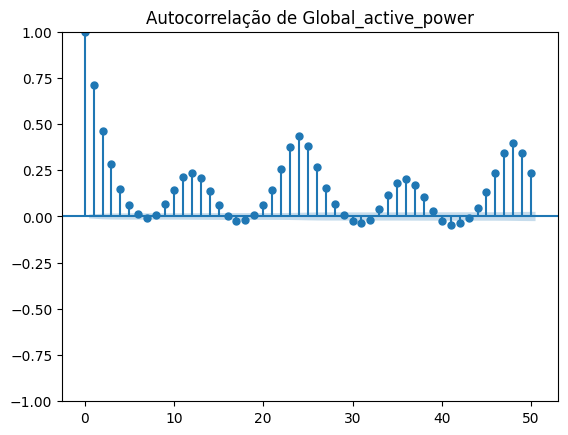

Autocorrelação (1h, 24h, 48h):
Lag 1h: 0.713
Lag 24h: 0.436
Lag 48h: 0.401


In [10]:
plt.figure(figsize=(10,5))
plot_acf(df_hourly['Global_active_power'].dropna(), lags=50)
plt.title('Autocorrelação de Global_active_power')
plt.show()


print("Autocorrelação (1h, 24h, 48h):")
for lag in [1,24,48]:
  corr = df_hourly['Global_active_power'].autocorr(lag=lag)
  print(f"Lag {lag}h: {corr:.3f}")

Sim, existem padrões diários repetidos. A autocorrelação significativa em 24h (0.436) e 48h (0.401) confirma a sazonalidade diária no consumo de energia.



# 23. PCA


In [11]:
features = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity']
X = df_hourly[features].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


print("Variância explicada:", pca.explained_variance_ratio_)

Variância explicada: [0.60013577 0.21497181]


# 24. Clusters no espaço PCA

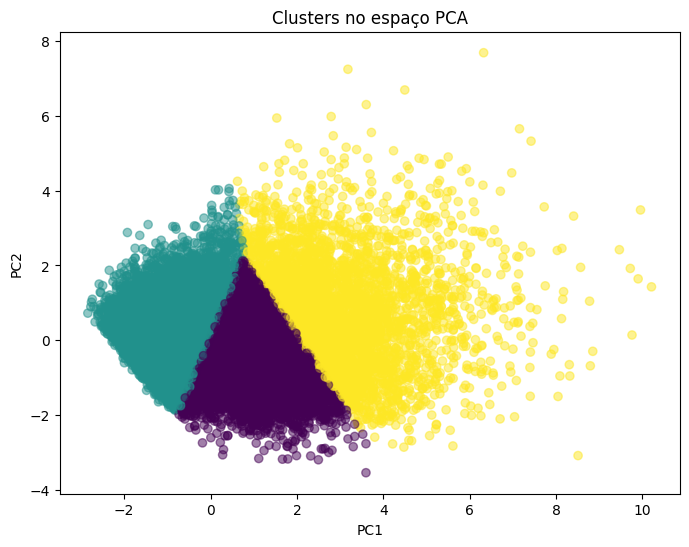

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.5)
plt.title("Clusters no espaço PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Não, os grupos não se separam de forma clara. Os clusters estão sobrepostos e misturados no espaço PCA, sem fronteiras bem definidas entre eles. A visualização mostra pontos de diferentes clusters intercalados, indicando que as características não permitem uma separação distinta dos grupos.

# 25. Regressão Linear vs Polinomial

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


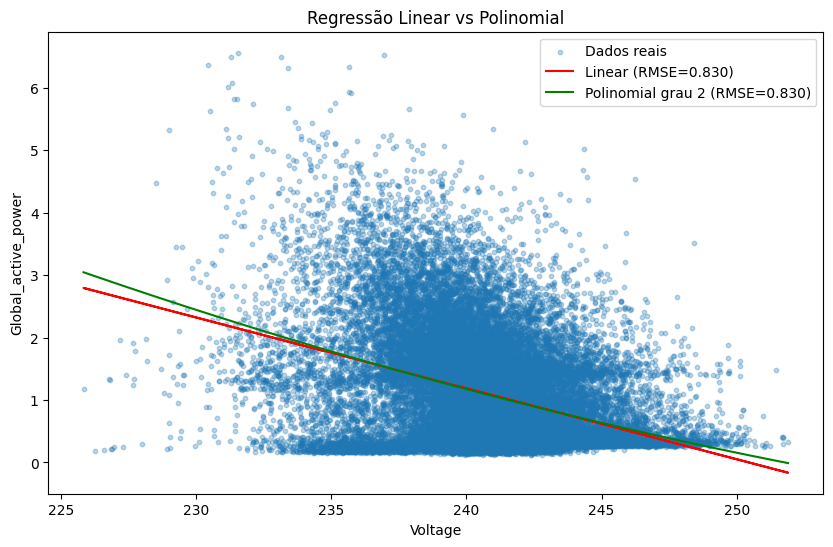

RMSE Linear: 0.8305
RMSE Polinomial: 0.8303


In [13]:
# Seleção de variáveis
X = df_hourly[['Voltage']].dropna()
y = df_hourly['Global_active_power'].dropna()
y = y.loc[X.index] # alinhar índices


# Linear
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)


rmse_lin = np.sqrt(mean_squared_error(y, y_pred_lin))


# Polinomial grau 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)


poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)


rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))


# Plot
plt.figure(figsize=(10,6))
plt.scatter(X, y, s=10, alpha=0.3, label="Dados reais")
plt.plot(X, y_pred_lin, color='red', label=f"Linear (RMSE={rmse_lin:.3f})")


# Ordenar valores para curva polinomial
X_sorted = np.sort(X.values, axis=0)
y_poly_sorted = poly_reg.predict(poly.transform(X_sorted))
plt.plot(X_sorted, y_poly_sorted, color='green', label=f"Polinomial grau 2 (RMSE={rmse_poly:.3f})")


plt.xlabel('Voltage')
plt.ylabel('Global_active_power')
plt.legend()
plt.title('Regressão Linear vs Polinomial')
plt.show()


print(f"RMSE Linear: {rmse_lin:.4f}")
print(f"RMSE Polinomial: {rmse_poly:.4f}")

#Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# 26. Carregamento e inspeção inicial

In [24]:
df = pd.read_csv('energydata_complete.csv')

# Normalizar nome das colunas para versões alternativas comuns
if 'To' in df.columns and 'T_out' not in df.columns:
    df.rename(columns={'To': 'T_out'}, inplace=True)

if 'Pressure' in df.columns and 'Press_mm_hg' not in df.columns:
    df.rename(columns={'Pressure': 'Press_mm_hg'}, inplace=True)

# Converter data/hora
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
else:
    # Caso raro: coluna chamada 'Date' ou semelhante
    date_like = [c for c in df.columns if c.lower() in ['date','datetime','time','timestamp']]
    if date_like:
        df[date_like[0]] = pd.to_datetime(df[date_like[0]])
        df.set_index(date_like[0], inplace=True)

print("\n[26] .info():")
df.info()
print("\n[26] .describe():")
print(df.describe())


[26] .info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 

# 27. Distribuição do consumo (Appliances)

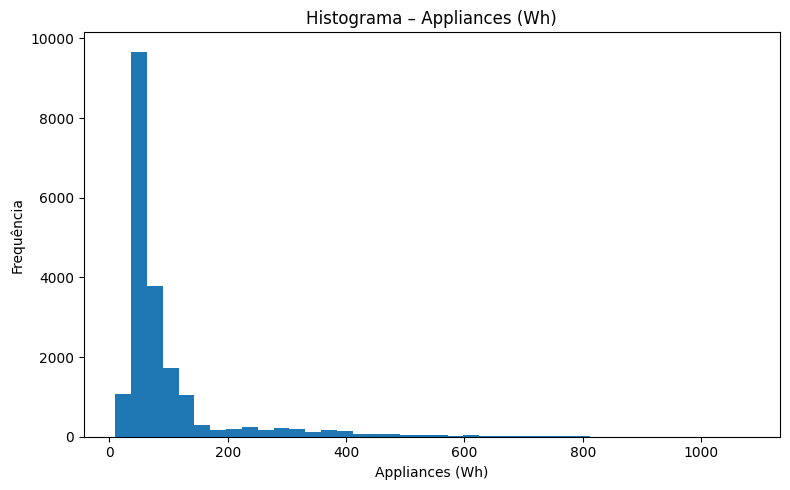

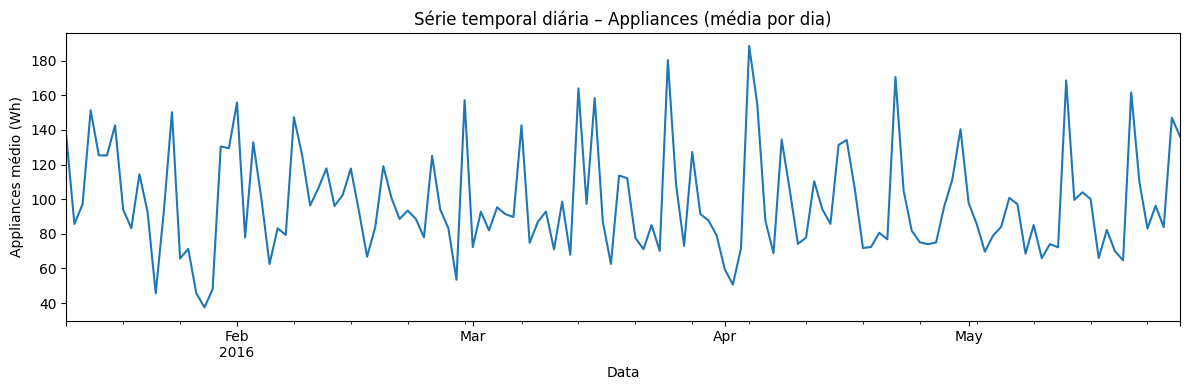


[27] Quantis Appliances:
0.50     60.0
0.75    100.0
0.90    196.0
0.95    330.0
Name: Appliances, dtype: float64
[27] Assimetria (skewness): 3.386


In [5]:
# Histograma
plt.figure(figsize=(8,5))
plt.hist(df['Appliances'].dropna(), bins=40)
plt.title('Histograma – Appliances (Wh)')
plt.xlabel('Appliances (Wh)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


# Série temporal (amostragem diária para visualização mais limpa)
plt.figure(figsize=(12,4))
(df['Appliances']
.resample('1D')
.mean()
.plot())
plt.title('Série temporal diária – Appliances (média por dia)')
plt.xlabel('Data')
plt.ylabel('Appliances médio (Wh)')
plt.tight_layout()
plt.show()


# Análise rápida de concentração
q = df['Appliances'].quantile([0.5, 0.75, 0.9, 0.95])
skew = df['Appliances'].skew()
print("\n[27] Quantis Appliances:")
print(q)
print(f"[27] Assimetria (skewness): {skew:.3f}")

O consumo se concentra predominantemente em valores baixos, com a maioria dos dados abaixo de 200 Wh.

# 28. Correlações com variáveis ambientais

In [6]:
# Selecionar variáveis ambientais típicas
env_cols = [
'lights',
'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4','T5','RH_5',
'T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
'T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint'
]
# Filtrar somente as que existem no df
env_cols = [c for c in env_cols if c in df.columns]


corr_with_appliances = df[env_cols + ['Appliances']].corr(numeric_only=True)['Appliances'].drop('Appliances').sort_values(ascending=False)


print("\n[28] Correlação de Pearson com Appliances (topo e base):")
print(pd.concat([corr_with_appliances.head(10), corr_with_appliances.tail(10)]))


[28] Correlação de Pearson com Appliances (topo e base):
lights         0.197278
T2             0.120073
T6             0.117638
T_out          0.099155
Windspeed      0.087122
RH_1           0.086031
T3             0.085060
T1             0.055447
T4             0.040281
T8             0.039572
T9             0.010010
RH_5           0.006955
Visibility     0.000230
Press_mm_hg   -0.034885
RH_9          -0.051462
RH_7          -0.055642
RH_2          -0.060465
RH_6          -0.083178
RH_8          -0.094039
RH_out        -0.152282
Name: Appliances, dtype: float64


As temperaturas (T2, T6, T_out) têm a maior relação positiva com o consumo de aparelhos, enquanto a umidade externa (RH_out) apresenta a maior correlação negativa. No geral, todas as correlações são fracas (próximas de zero), indicando que fatores ambientais têm influência limitada no consumo.

# 29. Normalização (Min-Max Scaling)

In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=num_cols)


print("\n[29] Exemplo de colunas escalonadas (primeiras linhas):")
print(df_scaled[num_cols[:6]].head())


[29] Exemplo de colunas escalonadas (primeiras linhas):
                     Appliances    lights       T1      RH_1        T2  \
date                                                                     
2016-01-11 17:00:00    0.046729  0.428571  0.32735  0.566187  0.225345   
2016-01-11 17:10:00    0.046729  0.428571  0.32735  0.541326  0.225345   
2016-01-11 17:20:00    0.037383  0.428571  0.32735  0.530502  0.225345   
2016-01-11 17:30:00    0.037383  0.571429  0.32735  0.524080  0.225345   
2016-01-11 17:40:00    0.046729  0.571429  0.32735  0.531419  0.225345   

                         RH_2  
date                           
2016-01-11 17:00:00  0.684038  
2016-01-11 17:10:00  0.682140  
2016-01-11 17:20:00  0.679445  
2016-01-11 17:30:00  0.678414  
2016-01-11 17:40:00  0.676727  


# 30. PCA (2 componentes) e plot


[30] Variância explicada pelos 2 PCs: [0.36426881 0.21103941]


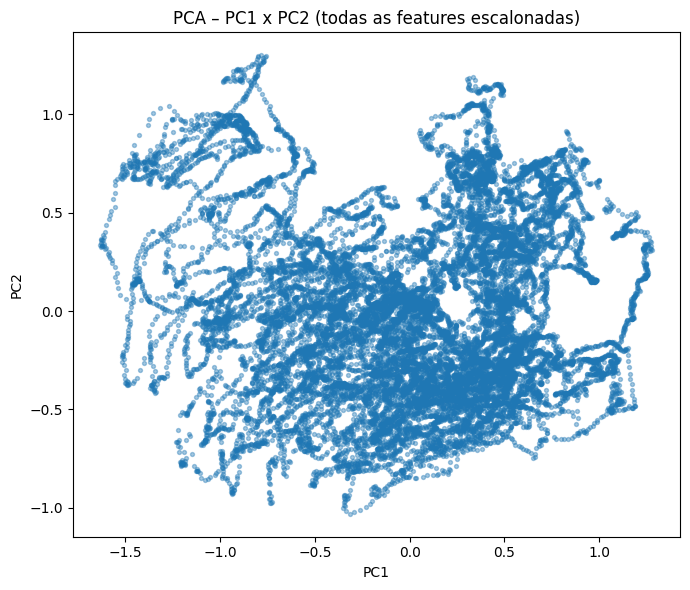

In [8]:
# PCA em features (exclui target e variáveis aleatórias se desejar)
pca_features = [c for c in num_cols if c != 'Appliances']
X_pca_src = df_scaled[pca_features].dropna()


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pca_src)


print("\n[30] Variância explicada pelos 2 PCs:", pca.explained_variance_ratio_)


plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.4)
plt.title('PCA – PC1 x PC2 (todas as features escalonadas)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

Não aparecem padrões ou agrupamentos naturais claros no gráfico de PCA.

A dispersão dos pontos forma uma nuvem homogênea sem clusters definidos ou estruturas evidentes, indicando que as duas primeiras componentes principais (que juntas explicam apenas 57% da variância) não capturam agrupamentos naturais nos dados. A ausência de padrões visíveis sugere que os dados não se separam naturalmente em grupos distintos neste espaço reduzido.

# 31. Regressão Linear Múltipla

In [9]:
# Usaremos apenas variáveis ambientais + lights (sem rv1/rv2) para a regressão
reg_features = [c for c in env_cols if c in df.columns]
reg_df = df.dropna(subset=['Appliances'] + reg_features).copy()


# Split temporal (80% treino, 20% teste) preservando ordem
n = len(reg_df)
train_end = int(n*0.8)
train_df = reg_df.iloc[:train_end]
test_df = reg_df.iloc[train_end:]


X_train = train_df[reg_features]
y_train = train_df['Appliances']
X_test = test_df[reg_features]
y_test = test_df['Appliances']


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


pred_lin = lin_reg.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, pred_lin))
mae_lin = mean_absolute_error(y_test, pred_lin)
r2_lin = r2_score(y_test, pred_lin)


print("\n[31] Regressão Linear Múltipla – métricas (teste):")
print(f"RMSE: {rmse_lin:.3f} | MAE: {mae_lin:.3f} | R²: {r2_lin:.3f}")


[31] Regressão Linear Múltipla – métricas (teste):
RMSE: 86.733 | MAE: 52.014 | R²: 0.092


# 32. Random Forest Regressor

In [10]:
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)


pred_rf = rf_reg.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)


print("\n[32] Random Forest Regressor – métricas (teste):")
print(f"RMSE: {rmse_rf:.3f} | MAE: {mae_rf:.3f} | R²: {r2_rf:.3f}")
print(f"Comparação RMSE (RF vs Linear): {rmse_rf:.3f} vs {rmse_lin:.3f}")


[32] Random Forest Regressor – métricas (teste):
RMSE: 229.870 | MAE: 203.197 | R²: -5.376
Comparação RMSE (RF vs Linear): 229.870 vs 86.733


# 33. K-Means clustering (k=3..5)


[33] Resumo por cluster (k=5) – médias de Appliances/lights/T_out/RH_out:
            Appliances    lights      T_out     RH_out
cluster_k5                                            
0            90.867561  3.805532   3.941285  84.405012
1           101.720755  2.200000  14.293723  79.034686
2            90.483396  4.022699   3.830204  84.368316
3            94.552340  5.839870   7.079163  88.220810
4           115.279938  2.672369  11.712608  60.672650


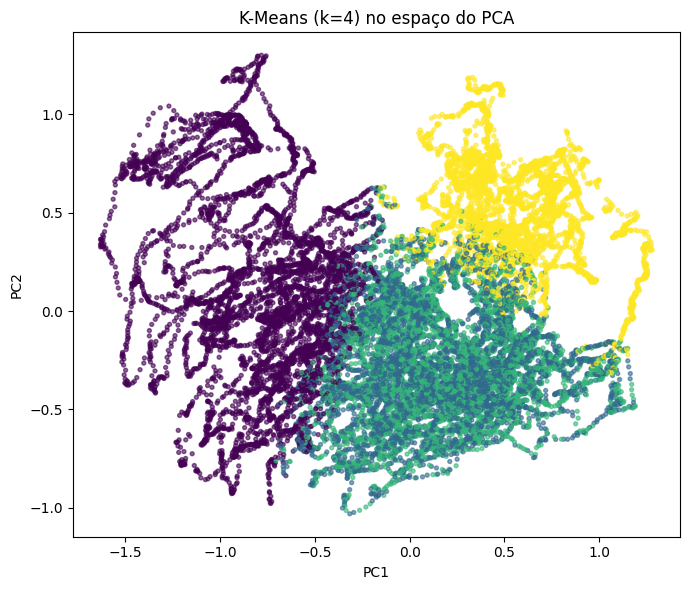

In [13]:
# Clustering nas features escalonadas (mesmo conjunto do PCA)
kmeans_results = {}
for k in [3,4,5]:
  km = KMeans(n_clusters=k, n_init=10, random_state=42)
  labels = km.fit_predict(X_pca_src)
  kmeans_results[k] = labels
# Resumo de perfis por cluster (média de Appliances e de algumas variáveis)
tmp = df.copy()
tmp = tmp.loc[X_pca_src.index]
tmp[f'cluster_k{k}'] = labels
summary = tmp.groupby(f'cluster_k{k}')[['Appliances','lights','T_out','RH_out']].mean(numeric_only=True)
print(f"\n[33] Resumo por cluster (k={k}) – médias de Appliances/lights/T_out/RH_out:")
print(summary)


# Plot para k=4 no espaço do PCA
labels4 = kmeans_results[4]
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels4, s=8, alpha=0.6)
plt.title('K-Means (k=4) no espaço do PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# 34. Classificação binária (alto vs baixo consumo)


Logistic Regression – Accuracy: 0.755 | Precision: 0.739 | Recall: 0.783 | F1: 0.760
Matriz de confusão:
[[1449  541]
 [ 425 1532]]


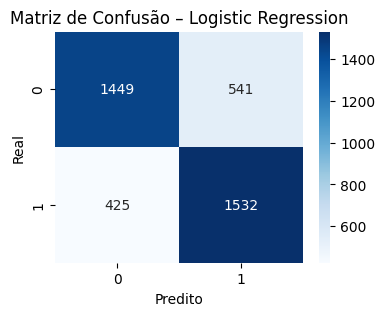


Random Forest Classifier – Accuracy: 0.544 | Precision: 0.522 | Recall: 0.946 | F1: 0.673
Matriz de confusão:
[[ 296 1694]
 [ 106 1851]]


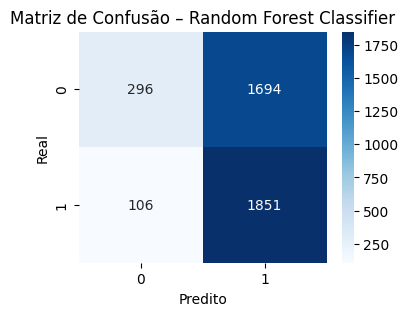

In [27]:
# Criar variável binária: alto vs baixo consumo
median_appl = df['Appliances'].median()
df['high_consumption'] = (df['Appliances'] > median_appl).astype(int)

# Selecionar features para o modelo (excluindo target e variáveis aleatórias rv1/rv2 se existirem)
reg_features = [c for c in df.columns if c not in ['Appliances','high_consumption','rv1','rv2']]

X = df[reg_features]
y = df['high_consumption']

# Escalonar features (importante para Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split temporal 80/20 preservando ordem
cut = int(len(df) * 0.8)
X_train, X_test = X_scaled[:cut], X_scaled[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)
pred_lr = logreg.predict(X_test)

# Random Forest Classifier
rf_cls = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_cls.fit(X_train, y_train)
pred_rf_cls = rf_cls.predict(X_test)

# Avaliação
def eval_cls(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name} – Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("Matriz de confusão:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão – {name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

# Resultados
eval_cls(y_test, pred_lr, 'Logistic Regression')
eval_cls(y_test, pred_rf_cls, 'Random Forest Classifier')

# 35. Avaliação de classificação

In [17]:
def eval_cls(y_true, y_pred, name):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  print(f"\n[35] {name} – Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
  print("Matriz de confusão:")
  print(confusion_matrix(y_true, y_pred))


print("\n[35] Logistic Regression (limiar 0.5)")
eval_cls(y_test, pred_lr, 'LogReg')


print("\n[35] Random Forest Classifier")
eval_cls(y_test, pred_rf_cls, 'RF Classifier')


# Observação sobre erro: verificar para qual classe o modelo erra mais
cm_lr = confusion_matrix(y_test, pred_lr)
cm_rf = confusion_matrix(y_test, pred_rf_cls)


fn_lr = cm_lr[1,0] # falsos negativos (alto consumo previsto como baixo)
fp_lr = cm_lr[0,1] # falsos positivos (baixo consumo previsto como alto)
fn_rf = cm_rf[1,0]
fp_rf = cm_rf[0,1]


print("\n[35] Erros por classe:")
print(f"LogReg – Falsos Negativos (alto→baixo): {fn_lr}, Falsos Positivos (baixo→alto): {fp_lr}")
print(f"RF – Falsos Negativos (alto→baixo): {fn_rf}, Falsos Positivos (baixo→alto): {fp_rf}")


[35] Logistic Regression (limiar 0.5)

[35] LogReg – Accuracy: 0.755 | Precision: 0.739 | Recall: 0.783 | F1: 0.760
Matriz de confusão:
[[1449  541]
 [ 425 1532]]

[35] Random Forest Classifier

[35] RF Classifier – Accuracy: 0.544 | Precision: 0.522 | Recall: 0.946 | F1: 0.673
Matriz de confusão:
[[ 296 1694]
 [ 106 1851]]

[35] Erros por classe:
LogReg – Falsos Negativos (alto→baixo): 425, Falsos Positivos (baixo→alto): 541
RF – Falsos Negativos (alto→baixo): 106, Falsos Positivos (baixo→alto): 1694
